In [1]:
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch
import tvm

from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T
from tvm import relax
from torch import fx

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensor expression

In [2]:
from tvm import te

A = te.placeholder((128, 128), name="A", dtype="float32")
B = te.placeholder((128, 128), name="B", dtype="float32")

def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
    assert A.shape[1] == B.shape[0]
    n = A.shape[0]
    m = B.shape[1]
    k = te.reduce_axis((0, A.shape[1]), name="k")
    return te.compute((n, m), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")

C = te_matmul(A, B)
te.create_prim_func([A, B, C]).show()

In [3]:
X1 = te.placeholder((10,), dtype="float32")

def te_relu(A: te.Tensor) -> te.Tensor:
    return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name='relu')

Y1 = te_relu(X1)
te.create_prim_func([X1, Y1]).show()

In [4]:
X2 = te.placeholder((10, 20), dtype="float32")
Y2 = te_relu(X2)
te.create_prim_func([X2, Y2]).show()

In [5]:
D = te_relu(C)
te.create_prim_func([A, B, D]).show()

BlockBuilder

In [6]:
A = relax.Var("A", relax.TensorStructInfo((128, 128), "float32"))
B = relax.Var("B", relax.TensorStructInfo((128, 128), "float32"))

bb = relax.BlockBuilder()
with bb.function("main"):
    with bb.dataflow():
        C = bb.emit_te(te_matmul, A, B)
        D = bb.emit_te(te_relu, C)
        R = bb.emit_output(D)
    bb.emit_func_output(R, params=[A, B])
    
MyModule = bb.get()
MyModule.show()

torch.fx call_function

In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.weight = nn.Parameter(torch.randn(128, 128))
        
    def forward(self, x):
        x = torch.matmul(x, self.weight)
        x = torch.relu(x)
        return x

    
model = MyModel()
fx_module = fx.symbolic_trace(model)
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7f822ab36e00>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7f822ab36e00>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


In [8]:
def map_param(param: nn.Parameter):
    ndim = len(param.data.shape)
    return relax.const(param.data.cpu().numpy(), relax.DynTensorType(ndim, "float32"))

def fetch_attr(fx_mod, target: str):
    target_atoms = target.split('.')
    attr_iter = fx_mod
    for i, atom in enumerate(target_atoms):
        if not hasattr(attr_iter, atom):
            raise RuntimeError(f"Node referenced nonexistant target {'.'.join(target_atoms[:i])}")
        attr_iter = getattr(attr_iter, atom)
    return attr_iter

def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
    input_index = 0
    node_map = {}
    named_modules = dict(fx_mod.named_modules())
    bb = relax.BlockBuilder()
    
    fn_inputs = []
    fn_output = None
    with bb.function("main"):
        with bb.dataflow():
            for node in fx_mod.graph.nodes:
                if node.op == "placeholder":
                    shape = input_shapes[input_index]
                    input_index += 1
                    input_var = relax.Var(node.target, relax.TensorStructInfo(shape, "float32"))
                    fn_inputs.append(input_var)
                    node_map[node] = input_var
                elif node.op == "get_attr":
                    node_map[node] = map_param(fetch_attr(fx_mod, node.target))
                elif node.op == "call_function":
                    node_map[node] = call_function_map[node.target](bb, node_map, node)
                elif node.op == "call_module":
                    named_module = named_modules[node.target]
                    node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
                elif node.op == "output":
                    output = node_map[node.args[0]]
                    assert fn_output is None
                    fn_output = bb.emit_output(output)
        bb.emit_func_output(output, fn_inputs)
        
    return bb.get()

In [9]:
def map_matmul(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    B = node_map[node.args[1]]
    return bb.emit_te(te_matmul, A, B)

def map_relu(bb, node_map, node: fx.Node):
    A = node_map[node.args[0]]
    return bb.emit_te(te_relu, A)

MyModule = from_fx(fx_module, input_shapes=[(1, 128)],
                   call_function_map={
                       torch.matmul: map_matmul,
                       torch.relu: map_relu
                   }, call_module_map={})

MyModule.show()

torch.fx call_module

In [10]:
import pickle as pkl

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)
        
    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x
    
mlp_model = MLP()
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", 'rb'))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params['w0'])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params['b0'])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params['w1'])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params['b1'])

fx_module = fx.symbolic_trace(mlp_model)
fx_module.graph.print_tabular()

opcode       name     target    args        kwargs
-----------  -------  --------  ----------  --------
placeholder  x        x         ()          {}
call_module  linear0  linear0   (x,)        {}
call_module  relu     relu      (linear0,)  {}
call_module  linear1  linear1   (relu,)     {}
output       output   output    (linear1,)  {}


In [11]:
from tvm import topi

def map_nn_linear(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit_te(topi.nn.dense, x, w)
    return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mod):
    return map_relu(bb, node_map, node)

MLPModule = from_fx(fx_module, input_shapes=[(1, 784)],
                    call_function_map={},
                    call_module_map={
                        torch.nn.Linear: map_nn_linear,
                        torch.nn.ReLU: map_nn_relu
                    })
MLPModule.show()

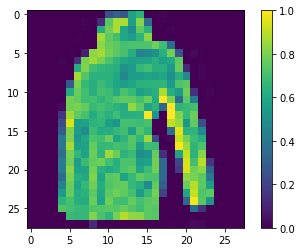

Class:  Coat


In [12]:
import matplotlib.pyplot as plt
import torchvision

test_data = torchvision.datasets.FashionMNIST(root="data", train=False, transform=torchvision.transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
img, lbl = next(iter(test_dataloader))
img = img.reshape(1, 28, 28).numpy()

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class: ", class_names[lbl[0]])

In [13]:
torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))
pred = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Pred: ", class_names[pred[0]])

Torch Pred:  Coat


In [14]:
ex = relax.vm.build(MLPModule, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_res = vm["main"](data_nd)

pred = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule pred: ", class_names[pred[0]])

MLPModule pred:  Coat


high level relax.function

In [15]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.nn.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight.T)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit(relax.op.matmul(x, w))
    return bb.emit(relax.op.add(y, b))

MLPModuleHighLevel = from_fx(fx_module,
                             input_shapes=[(1, 784)],
                             call_function_map={},
                             call_module_map={
                                 torch.nn.Linear: map_nn_linear_op,
                                 torch.nn.ReLU: map_nn_relu_op
                             })

MLPModuleHighLevel.show()